# Kuramoto Model For Prediction in Uncinate Circuit

## Introduction

### Major Depressive Disorder (MDD)

Depression refers to a transient mood state that any normal individual will likely experience. However, MDD is a clinical condition, in which the individual experiences the depressive state for prolonged periods of time. MDD is one of the most widely prevalent clinical disorders, with almost 5% of the general population meet the standards for MDD. There are various risk factors for MDD, including genetics, personality traits, and traumatic experiences.<sup>[1]</sup>

### Deep Brain Stimulation (DBS)

The normal courses of treatment for MDD include psychotherapy, drug medications, and electroconvulsive therapy. However, there are still some cases of treatment-resistant depression. Deep brain stimulation, especially in the subcallosal cingulate (SCC) region, has been shown to high efficacy to return patients back to their normal state. Direct implantation of active electrodes in the SCC region has been shown to reduce local cortical blood flow, and reduce depression symptoms. Despite the shown effectiveness of this treatment, there is little knowledge on the mechanism behind this treatment.<sup>[2,3]</sup>

### Network Oscillatory Activity

Abnormal neural network activity is suspected to be the underlying cause of MDD. Measuring local field potentials (LFP) using various electrophysiology measures, such as EEG, we can find coherence measures to quantify how MDD affects certain brain networks. Using dynamic casual modeling to find the best-fit model, we can infer information about the relations in connectivity between network activity, and optimize certain parameters for DBS.<sup>[4]</sup>

### Kuramoto Model

The basic model used for characterizing the system is the Kuramoto model, first developed by Yoshiki Kuramoto. The Kuramoto model has been used to describe various network oscillation paradigms, including organism population and environmental dynamics. The Kuramoto model is also robust in characterizing the coupling between oscillations in different brain regions. <sup>[5]</sup> 



In [2]:
%reset
%matplotlib inline
import networkx as nx
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Exploring the Kuramoto Model

### Structure
The underlying structure of a basic Kuramoto model is: $
\begin{equation}
\dot{\phi_i} = \omega_i + \frac{K}{N} \sum\limits_{j \in N_i} f(\phi_j - \phi_i)
\end{equation}
$, where phase corresponds to the progress of an action potential, K is the coupling constant between nodes, omega is the intrinsic speed of firing for a node, and f is the function of coupling, which is usually sin or cos.
Using the graphical formulation of the Kuramoto Model, we get:  
$
\begin{equation}
\dot{\vec{\phi}} = \vec{\omega} + D f( D^T \vec{\phi})
\end{equation}
$, where D is an oriented incidence matrix of the graph.

### SCC Network

The network consists of 6 nodes, corresponding to different brain regions in the SCC, and the edges representing different white matter tracts between them. 

### Approximation of the Behavior

Euler's approximation and Runge-Kutta's approximation was employed to sufficiently approximate the behavior of the network.

### Getting more complex behavior

For simulating different conductances between different brain regions, a diagonal weight matrix was multiplied to the incidence matrix.

For simulating different coherences between regions, different functions were applied to each row of the incidence matrix.

For simulating range of coherences between tracts, a linear combination of sin and cos was applied to be directly formulating from coherence:
$
\begin{equation}
Asin(x) + Bcos(x) = \sqrt{A^2 + B^2}sin(arctan(A/B))
\end{equation}
$

$
\begin{equation}
A + B = 1
\end{equation}
$

$
\begin{equation}
A = coherence, B = 1 - coherence
\end{equation}
$


In [10]:
class KModel:
    def __init__(self,l = 1, u = .2, coh = [1]*7, weights = [1]*7, K = 10, dt = .05):
        #Graph representation of network
        nodes = [1,2,3,4,5,6]
        self.G = nx.Graph()
        self.G.add_nodes_from(nodes)
        self.G.add_edges_from([(1,2),(2,3),(1,3),(3,4),(4,5),(4,6),(5,6)])
        
        self.states = np.matrix(np.random.uniform(0,2*np.pi,[len(nodes),1])) #memory of phases
        self.w = np.matrix(np.random.normal(l,u,[len(nodes),1])) #initial intrinsic freq.
        self.K = K #Coupling constant
        self.coh = coh #measures of coherence between each edge
        self.weights = weights
        self.t = 0 #time
        self.dt = dt #time step
    
    #Kuramoto differential equation
    def phase_dev(self,phase):
        D = (nx.incidence_matrix(self.G, oriented = True)).todense()
        W = self.edge_w(self.weights)
        E = self.edge_func(W*D.T)
        return self.int_frq() - self.K/len(self.G) * D * E
    
    #euler method approximation of behavior
    def euler_step(self):
        new_state = self.states[:,-1] + self.phase_dev(self.states[:,-1])*self.dt
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
       
    #runge-Kutta approximation of behavior
    def runge_kutta_step(self):
        k1 = self.phase_dev(self.states[:,-1])*self.dt
        k2 = self.phase_dev(self.states[:,-1]+ .5*k1)*self.dt
        k3 = self.phase_dev(self.states[:,-1]+ .5*k2)*self.dt
        k4 = self.phase_dev(self.states[:,-1]+ k3)*self.dt
        new_state = self.states[:,-1] + (k1+ 2*k2 + 2*k3 + k4)/6
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
    
    #time step function
    def step(self):
        self.euler_step()
    
    #coherence function
    def coh_func(self,coh,x):
        c1 = 1 - coh
        c2 = coh
        A = np.sqrt(c1**2+c2**2)
        if coh == 0:
            offset = np.pi/2
        else:
            offset = np.arctan(c1/c2)
        return A*np.sin(x+offset)
    
    #edge weight diagonal matrix
    def edge_w(self,weights):
        return np.diag(weights)
    
    #applying function to phase difference for each edge 
    def edge_func(self,M):
        PDiff = M * self.states[:,-1]
        PDiff = PDiff.tolist()
        e = [self.coh_func(self.coh[x],PDiff[x][0]) for x in range(0,len(self.coh))]
        return np.matrix(e).T   
    
    #function for intrinsic frequencies
    def int_frq(self):
        return self.w

#### Runs specified kuramoto model for a given amount of time, default is 10 sec.

In [4]:
K= KModel()
def run_model(K,t = 10):
    for ts in range(0,int(t/K.dt)):
        K.step()
    return K
run_model(K,10)

#### Displays states of each node over a certain time interval, default is 10 sec.

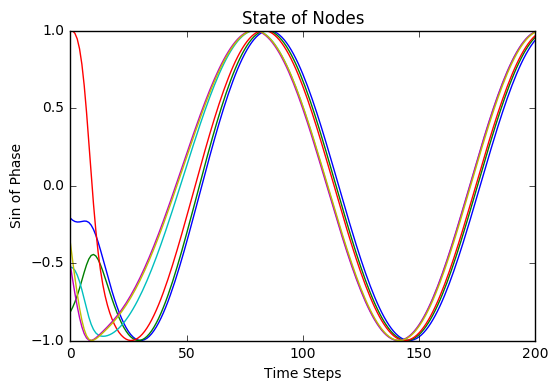

In [11]:
K = KModel()
def state_course(K, time = 10):
    run_model(K,time)
            
    plt.figure()
    plt.plot(np.sin(K.states.T))
    plt.xlabel('Time Steps')
    plt.ylabel('Sin of Phase')
    plt.title('State of Nodes')
    plt.xlim((0,int(time/K.dt)))
    plt.show()
state_course(K)

#### A visual representation of the network graph.

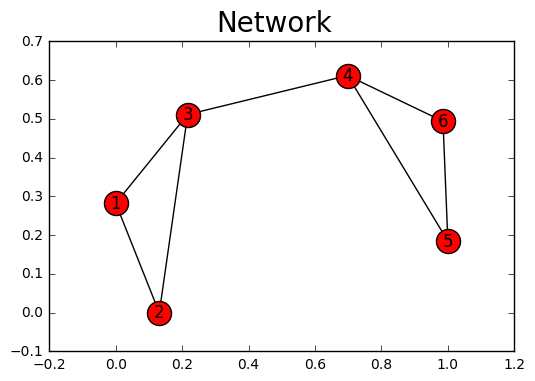

In [7]:
K = KModel()
def K_network(K):
    fig = plt.figure()
    fig.suptitle('Network', fontsize=20)
    nx.draw_networkx(K.G)
K_network(K)

#### A polar representation of the different current phases of the kuramoto model.

In [ ]:
K = KModel()
def phaseplot(K):   
    plt.figure()
    ax = plt.subplot(111,projection='polar')
    ax.stem(K.states[:,-1],np.ones(K.states[:,-1].shape))
    ax.set_title('Current Phases')
    ax.set_rmax(1)
    plt.show()
phaseplot(K)

#### An animation of the kuramoto model, in real time.

In [ ]:
K = KModel()
def animate(K,t):
    %matplotlib notebook
    import time
    import pylab as plt
    t_full = t
    radii = np.ones(K.states[:,-1].shape)
    
    fig,ax = plt.subplots(1, 1, subplot_kw=dict(polar=True))
    ax.set_rmax(10)
    ax.set_title('Phase Propogation')
    for i in range(0,int(t_full/K.dt)):
        K.step()
        ax.lines = []
        ax.stem(K.states[:,-1],radii)
        fig.canvas.draw()
        if(K.dt > .06):
            time.sleep(K.dt-.06)
animate(K,10)
%matplotlib inline

#### A spectogram of the kuramoto for a given time and sampling rate, default is 10 sec, and 1000 Hz respectively.

In [ ]:
K = KModel()
def K_spectogram(K, t = 1000, sr = 100):
    K.dt = 1/sr
    run_model(K, t)
    for i in range(0,K.states.shape[0]):
        f, t, s = sig.spectrogram(10*np.sin(np.array(K.states[i,:])[0]), sr, nperseg = 512, nfft = 2**9)  ###
        plt.pcolormesh(t, f, s)
        plt.ylabel('Frequency (Hz)')
        plt.title('Node' +str(i+1))
        plt.ylim(0,int(max(K.w.tolist())[0]*2))
        plt.xlabel('Time (s)')
        plt.show()
    
K_spectogram(K)

## References
<i>
[1]  Fava, M., & Kendler, K. S. (2000). Major Depressive disorder. Neuron, 28(2), 335–341. doi:10.1016/s0896-6273(00)00112-4 <br><br>
[2] Mayberg, H. S., Lozano, A. M., Voon, V., McNeely, H. E., Seminowicz, D., Hamani, C., … Kennedy, S. H. (2005). Deep brain stimulation for treatment-resistant depression. Neuron, 45(5), 651–660. doi:10.1016/j.neuron.2005.02.014 <br><br>
[3] Riva-Posse, P., Choi, K. S., Holtzheimer, P. E., McIntyre, C. C., Gross, R. E., Chaturvedi, A., … Mayberg, H. S. (2014). Defining critical white matter pathways mediating successful Subcallosal Cingulate deep brain stimulation for treatment-resistant depression. Biological Psychiatry, 76(12), 963–969. doi:10.1016/j.biopsych.2014.03.029 <br><br>
[4] Einevoll, G. T., Kayser, C., Logothetis, N. K., & Panzeri, S. (2013). Modelling and analysis of local field potentials for studying the function of cortical circuits. Nature Reviews Neuroscience, 14(11), 770–785. doi:10.1038/nrn3599 <br><br>
[5] Rodrigues, F. A., Peron, T. K. Dm., Ji, P., & Kurths, J. (2016). The Kuramoto model in complex networks. Physics Reports, 610, 1–98. doi:10.1016/j.physrep.2015.10.008 <br><br>
[6] Breakspear, Research, M. H., Brisbane, R., Hospital, W., Services, M. H., Institute, T. B. D., … Wales, N. S. (2010). Generative models of cortical Oscillations: Neurobiological implications of the Kuramoto model. Frontiers in Human Neuroscience, 4, . doi:10.3389/fnhum.2010.00190 <br><br>
[7] Cumin, D., & Unsworth, C. P. (2007). Generalising the Kuramoto model for the study of neuronal synchronisation in the brain. Physica D: Nonlinear Phenomena, 226(2), 181–196. doi:10.1016/j.physd.2006.12.004 <br><br>
[8] Jadbabaie, A., Motee, N., & Barahona, M. (2005). On the Stability of the Kuramoto Model of Coupled Nonlinear Oscillators. 2004 American Control Conference <br><br>
[9] Ibáñez-Molina, A. J., & Iglesias-Parro, S. (2016). Neurocomputational model of EEG complexity during mind wandering. Frontiers in Computational Neuroscience, 10, . doi:10.3389/fncom.2016.00020 <br><br>
</i>